In [ ]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

# #Load model
# xml = '/home/sysidea/leap_hand_mujoco/model/leap hand/index_finger.xml' # add your path
# model = mujoco.MjModel.from_xml_path(xml)
# data = mujoco.MjData(model)
# renderer = mujoco.Renderer(model)

In [ ]:
# camera = mujoco.MjvCamera()
# mujoco.mjv_defaultFreeCamera(model, camera)
# camera.distance = 1
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)

# Set camera position
camera.lookat[:] = np.array([0.0, 0.0, 0.0])  # Point in space the camera is looking at
camera.azimuth = 135                   # Horizontal angle in degrees
camera.elevation = -10                      # Vertical angle in degrees
camera.distance = 1                         # Distance from the lookat point


In [ ]:
#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [pi/6,0,pi/6,pi/6]

#Initial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian 
# coordinates
target = data.body('fingertip').xpos
print("Target =>",target)

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point = data.body('fingertip').xpos.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point = data.body('fingertip').xpos.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point)
print("Desire point =>", result_point, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)


In [ ]:
class GradientDescentIK:
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
    
    def check_joint_limits(self, q):
        """Check if the joints is under or above its limits"""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))

    #Gradient Descent pseudocode implementation
    def calculate(self, goal, init_q, body_id):
        """Calculate the desire joints angles for goal"""
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        current_pose = self.data.body(body_id).xpos
        error = np.subtract(goal, current_pose)

        while (np.linalg.norm(error) >= self.tol):
            #calculate jacobian
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal, body_id)
            #calculate gradient
            grad = self.alpha * self.jacp.T @ error
            #compute next step
            self.data.qpos += self.step_size * grad
            #check joint limits
            self.check_joint_limits(self.data.qpos)
            #compute forward kinematics
            mujoco.mj_forward(self.model, self.data) 
            #calculate new error
            error = np.subtract(goal, self.data.body(body_id).xpos)        

    
#Init variables.
body_id = model.body('fingertip').id
jacp = np.zeros((3, model.nv)) #translation jacobian
jacr = np.zeros((3, model.nv)) #rotational jacobian
goal = [ 0.0565407,   0.0226578,  -0.07722874]
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0]

ik = GradientDescentIK(model, data, step_size, tol, alpha, jacp, jacr)

#Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1) #reset qpos to initial value
ik.calculate(goal, init_q, body_id) #calculate the q angles

result = data.qpos.copy()

#Plot results
print("Results")
data.qpos = qpos0
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body('fingertip').xpos
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("testing point =>", target)
print("Gradient Descent result =>", result_point, "\n")

images = {
    'Testing point': target_plot,
    'Gradient Descent result': result_plot,
}

media.show_images(images)


Desired orientation of end effector along with position (Index finger)

In [ ]:
#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [pi/6,0,pi/6,pi/6]

#Initial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian 
# coordinates
target_pos = data.body('fingertip').xpos
target_mat=data.body('fingertip').xmat
print("Target =>",target_pos,target_mat)

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point_pos = data.body('fingertip').xpos.copy()
init_point_rot = data.body('fingertip').xmat.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point_pos = data.body('fingertip').xpos.copy()
result_point_rot = data.body('fingertip').xmat.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point_pos)
print("Desire point =>", result_point_pos, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)


In [ ]:
class GradientDescentIK:
    def __init__(self,xml_path):
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data = mujoco.MjData(self.model)
        self.jacp = np.zeros((3, self.model.nv))  # translation jacobian
        self.jacr = np.zeros((3, self.model.nv)) 
        self.step_size = 0.5
        self.tol = 0.01
        self.alpha = 0.5
        self.init_q = [0.0, 0.0, 0.0, 0.0]  
    
    def check_joint_limits(self, q):
        """Check if the joints are under or above their limits."""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))


    def calculate(self, goal_pos, goal_rot, bodypart):
        self.data.qpos = self.init_q
        mujoco.mj_forward(self.model, self.data)

        body_id= self.model.body(bodypart).id
        
        # Current pose and orientation
        current_pos = self.data.body(body_id).xpos
        current_rot = self.data.body(body_id).xmat.reshape(3, 3)

        # Position and orientation error
        pos_error = np.subtract(goal_pos, current_pos)
        rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                           np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                           np.cross(current_rot[:, 2], goal_rot[:, 2]))

        # Combine position and orientation errors
        error = np.concatenate([pos_error, rot_error])

        max_iterations = 1000
        iteration = 0

        while np.linalg.norm(error) >= self.tol and iteration < max_iterations:
            # Calculate Jacobian for position and orientation
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal_pos, body_id)
            full_jacobian = np.vstack((self.jacp, self.jacr))
            
            # Calculate gradient
            grad = self.alpha * full_jacobian.T @ error
            
            # Compute next step
            self.data.qpos += self.step_size * grad
            
            # Check joint limits
            self.check_joint_limits(self.data.qpos)
            
            # Compute forward kinematics
            mujoco.mj_forward(self.model, self.data)
            
            # Update position and orientation error
            current_pos = self.data.body(body_id).xpos
            current_rot = self.data.body(body_id).xmat.reshape(3, 3)
            pos_error = np.subtract(goal_pos, current_pos)
            rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                               np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                               np.cross(current_rot[:, 2], goal_rot[:, 2]))
            error = np.concatenate([pos_error, rot_error])

            iteration += 1

        if iteration >= max_iterations:
            print("Warning: Maximum iterations reached. The solution may not have converged.")
        
        result = self.data.qpos.copy()
        return result

Thumb

In [ ]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

#Load model
xml = '/home/sysidea/leap_hand_mujoco/model/leap hand/thumb.xml' # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

In [ ]:
# camera = mujoco.MjvCamera()
# mujoco.mjv_defaultFreeCamera(model, camera)
# camera.distance = 1
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)

# Set camera position
camera.lookat[:] = np.array([0.0, 0.0, 0.0])  # Point in space the camera is looking at
camera.azimuth = 0                 # Horizontal angle in degrees
camera.elevation = -10                      # Vertical angle in degrees
camera.distance = 0.8                    # Distance from the lookat point


In [ ]:
#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [pi/2,pi/6,pi/6,pi/6]

#Initial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian 
# coordinates
target_pos = data.body('thumb_fingertip_4').xpos
target_mat=data.body('thumb_fingertip_4').xmat
print("Target =>",target_pos,target_mat)

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point_pos = data.body('thumb_fingertip_4').xpos.copy()
init_point_rot = data.body('thumb_fingertip_4').xmat.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point_pos = data.body('thumb_fingertip_4').xpos.copy()
result_point_rot = data.body('thumb_fingertip_4').xmat.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point_pos)
print("Desire point =>", result_point_pos, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)


In [ ]:
import numpy as np

class GradientDescentIK:
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr
    
    def check_joint_limits(self, q):
        """Check if the joints are under or above their limits."""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))

    def calculate(self, goal_pos, goal_rot, init_q, body_id):
        """Calculate the desired joint angles for goal position and orientation."""
        self.data.qpos = init_q
        mujoco.mj_forward(self.model, self.data)
        
        # Current pose and orientation
        current_pos = self.data.body(body_id).xpos
        current_rot = self.data.body(body_id).xmat.reshape(3, 3)

        # Position and orientation error
        pos_error = np.subtract(goal_pos, current_pos)
        rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                           np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                           np.cross(current_rot[:, 2], goal_rot[:, 2]))

        # Combine position and orientation errors
        error = np.concatenate([pos_error, rot_error])

        while np.linalg.norm(error) >= self.tol:
            # Calculate Jacobian for position and orientation
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal_pos, body_id)
            full_jacobian = np.vstack((self.jacp, self.jacr))
            
            # Calculate gradient
            grad = self.alpha * full_jacobian.T @ error
            
            # Compute next step
            self.data.qpos += self.step_size * grad
            
            # Check joint limits
            self.check_joint_limits(self.data.qpos)
            
            # Compute forward kinematics
            mujoco.mj_forward(self.model, self.data)
            
            # Update position and orientation error
            current_pos = self.data.body(body_id).xpos
            current_rot = self.data.body(body_id).xmat.reshape(3, 3)
            pos_error = np.subtract(goal_pos, current_pos)
            rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                               np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                               np.cross(current_rot[:, 2], goal_rot[:, 2]))
            error = np.concatenate([pos_error, rot_error])

# Init variables
body_id = model.body('thumb_fingertip_4').id
jacp = np.zeros((3, model.nv))  # translation jacobian
jacr = np.zeros((3, model.nv))  # rotational jacobian
goal_pos = [-0.05486681, -0.00016167, -0.09327918]  # desired position of the end effector
goal_rot=np.array([[-4.33012702e-01, -7.50000000e-01,  5.00000000e-01],  [2.50000000e-01,
  4.33012702e-01,  8.66025404e-01], [-8.66025404e-01,  5.00000000e-01,
  2.22044605e-16]])
step_size = 0.5
tol = 0.01
alpha = 0.5
init_q = [0.0, 0.0, 0.0, 0.0]  # initial joint configuration

# Initialize IK solver
ik = GradientDescentIK(model, data, step_size, tol, alpha, jacp, jacr)

# Reset qpos to the initial keyframe
mujoco.mj_resetDataKeyframe(model, data, 1)

# Calculate the desired joint angles using the IK solver
ik.calculate(goal_pos,goal_rot, init_q, body_id)

# Get the result after IK calculation
result = data.qpos.copy()

# Plot results
print("Results")
# Visualize the target point
data.qpos = qpos0  # reset to initial configuration
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

# Visualize the result after Gradient Descent IK
data.qpos = result  # set the configuration to the IK result
mujoco.mj_forward(model, data)
result_point = data.body(body_id).xpos.copy()  # store the resultant position
renderer.update_scene(data, camera)
result_plot = renderer.render()

# Print positions
print("Testing point =>", goal_pos)
print("Gradient Descent result =>", result_point, "\n")

# Display images
images = {
    'Testing point': target_plot,
    'Gradient Descent result': result_plot,
}

media.show_images(images)


Using site position

Target => [ 0.0465407   0.0076578  -0.10922874] [-1.92592994e-32 -1.00000000e+00  3.92523115e-16 -1.00000000e+00
 -1.92592994e-32  0.00000000e+00  0.00000000e+00 -3.92523115e-16
 -1.00000000e+00]
Results
initial point => [ 0.11410475  0.0076578  -0.0295224 ]
Desire point => [ 0.0465407   0.0076578  -0.10922874] 



Initial position,Desire end effector position

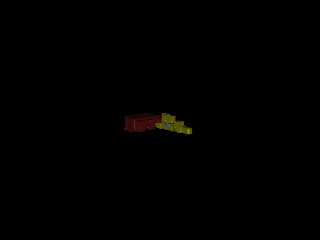
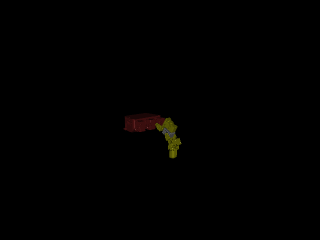

In [1]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media

#Load model
xml = '/home/sysidea/leap_hand_mujoco/model/leap hand/index_finger.xml' # add your path
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)

# Set camera position
camera.lookat[:] = np.array([0.0, 0.0, 0.0])  # Point in space the camera is looking at
camera.azimuth = 135                   # Horizontal angle in degrees
camera.elevation = -10                      # Vertical angle in degrees
camera.distance = 1                         # Distance from the lookat point


#Put a position of the joints to get a test point
pi = np.pi
data.qpos = [pi/6,0,pi/6,pi/6]

#Initial joint position
qpos0 = data.qpos.copy()

#Step the simulation.
mujoco.mj_forward(model, data)

#Use the last piece as an "end effector" to get a test point in cartesian 
# coordinates
target_pos = data.site('contact_index').xpos
target_mat=data.site('contact_index').xmat
print("Target =>",target_pos,target_mat)

#Plot results
print("Results")
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
init_point_pos = data.site('contact_index').xpos.copy()
init_point_rot = data.site('contact_index').xmat.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = qpos0
mujoco.mj_forward(model, data)
result_point_pos = data.site('contact_index').xpos.copy()
result_point_rot = data.site('contact_index').xmat.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("initial point =>", init_point_pos)
print("Desire point =>", result_point_pos, "\n")

images = {
    'Initial position': target_plot,
    ' Desire end effector position': result_plot,
}

media.show_images(images)


Results
Testing point => [ 0.0465407   0.0076578  -0.10922874]
Gradient Descent result => [ 0.04670659  0.00765722 -0.10925988] 



Testing point,Gradient Descent result

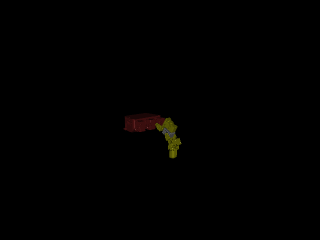
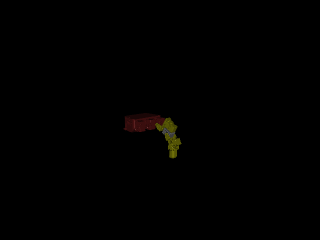

In [2]:
import numpy as np
import mujoco
import mujoco.viewer as viewer
import mediapy as media


class GradientDescentIK:
    def __init__(self,xml_path):
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data = mujoco.MjData(self.model)
        self.jacp = np.zeros((3, self.model.nv))  # translation jacobian
        self.jacr = np.zeros((3, self.model.nv)) 
        self.step_size = 0.5
        self.tol = 0.01
        self.alpha = 0.5
        self.init_q = [0.0, 0.0, 0.0, 0.0]  
    
    def check_joint_limits(self, q):
        """Check if the joints are under or above their limits."""
        for i in range(len(q)):
            q[i] = max(self.model.jnt_range[i][0], min(q[i], self.model.jnt_range[i][1]))


    def calculate(self, goal_pos, goal_rot, site_name):
        self.data.qpos = self.init_q
        mujoco.mj_forward(self.model, self.data)

        site_id= self.model.site(site_name).id
        
        # Current pose and orientation
        current_pos = self.data.site(site_id).xpos
        current_rot = self.data.site(site_id).xmat.reshape(3, 3)

        # Position and orientation error
        pos_error = np.subtract(goal_pos, current_pos)
        rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                           np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                           np.cross(current_rot[:, 2], goal_rot[:, 2]))

        # Combine position and orientation errors
        error = np.concatenate([pos_error, rot_error])

        max_iterations = 1000
        iteration = 0

        while np.linalg.norm(error) >= self.tol and iteration < max_iterations:
            # Calculate Jacobian for position and orientation
            mujoco.mj_jacSite(self.model, self.data, self.jacp, self.jacr, site_id)
            full_jacobian = np.vstack((self.jacp, self.jacr))
            
            # Calculate gradient
            grad = self.alpha * full_jacobian.T @ error
            
            # Compute next step
            self.data.qpos += self.step_size * grad
            
            # Check joint limits
            self.check_joint_limits(self.data.qpos)
            
            # Compute forward kinematics
            mujoco.mj_forward(self.model, self.data)
            
            # Update position and orientation error
            current_pos = self.data.site(site_id).xpos
            current_rot = self.data.site(site_id).xmat.reshape(3, 3)
            pos_error = np.subtract(goal_pos, current_pos)
            rot_error = 0.5 * (np.cross(current_rot[:, 0], goal_rot[:, 0]) +
                               np.cross(current_rot[:, 1], goal_rot[:, 1]) +
                               np.cross(current_rot[:, 2], goal_rot[:, 2]))
            error = np.concatenate([pos_error, rot_error])

            iteration += 1

        if iteration >= max_iterations:
            print("Warning: Maximum iterations reached. The solution may not have converged.")
        
        result = self.data.qpos.copy()
        return result
    
# Init variables
ik=GradientDescentIK('/home/sysidea/leap_hand_mujoco/model/leap hand/index_finger.xml')
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(ik.model, camera)

# Set camera position
camera.lookat[:] = np.array([0.0, 0.0, 0.0])  # Point in space the camera is looking at
camera.azimuth = 135                   # Horizontal angle in degrees
camera.elevation = -10                      # Vertical angle in degrees
camera.distance = 1                         # Distance from the lookat point

goal_pos = np.array([ 0.0465407,   0.0076578,  -0.10922874])  # desired position of the end effector
goal_rot=np.array([[-1.92592994e-32, -1.00000000e+00,  3.92523115e-16],
                     [-1.00000000e+00, -1.92592994e-32,  0.00000000e+00],
                     [0.00000000e+00, -3.92523115e-16, -1.00000000e+00]])

# Reset qpos to the initial keyframe
mujoco.mj_resetDataKeyframe(ik.model, ik.data, 1)

site_name = 'contact_index'
site_id= ik.model.site(site_name).id

# Calculate the desired joint angles using the IK solver
ik.calculate(goal_pos,goal_rot, site_name)

# Get the result after IK calculation
result = ik.data.qpos.copy()

# Plot results
print("Results")
# Visualize the target point
ik.data.qpos = qpos0  # reset to initial configuration
mujoco.mj_forward(ik.model, ik.data)
renderer.update_scene(ik.data, camera)
target_plot = renderer.render()

# Visualize the result after Gradient Descent IK
ik.data.qpos = result  # set the configuration to the IK result
mujoco.mj_forward(ik.model, ik.data)
result_point =ik.data.site(site_name).xpos.copy()  # store the resultant position
renderer.update_scene(ik.data, camera)
result_plot = renderer.render()

# Print positions
print("Testing point =>", goal_pos)
print("Gradient Descent result =>", result_point, "\n")

# Display images
images = {
    'Testing point': target_plot,
    'Gradient Descent result': result_plot,
}

media.show_images(images)
